In [1]:
!pip install tensorflow tensorflow-datasets --quiet

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [10]:
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib.pyplot

In [2]:
# Load the dataset (as supervised: (image, label))
(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

IMG_SIZE = (160, 160)  # MobileNetV2 default input size

def format_example(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

BATCH_SIZE = 32

train_batches = ds_train.map(format_example).batch(BATCH_SIZE).prefetch(1)
val_batches = ds_val.map(format_example).batch(BATCH_SIZE).prefetch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.MXHQPQ_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [4]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Feature extraction

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=5  # You can increase this if you want
)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 552s 931ms/step - accuracy: 0.9039 - loss: 0.2188 - val_accuracy: 0.9783 - val_loss: 0.0646
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 596s 1s/step - accuracy: 0.9483 - loss: 0.1257 - val_accuracy: 0.9798 - val_loss: 0.0603
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 615s 1s/step - accuracy: 0.9538 - loss: 0.1163 - val_accuracy: 0.9813 - val_loss: 0.0576
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 533s 916ms/step - accuracy: 0.9520 - loss: 0.1116 - val_accuracy: 0.9796 - val_loss: 0.0583
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 525s 901ms/step - accuracy: 0.9523 - loss: 0.1155 - val_accuracy: 0.9781 - val_loss: 0.0591


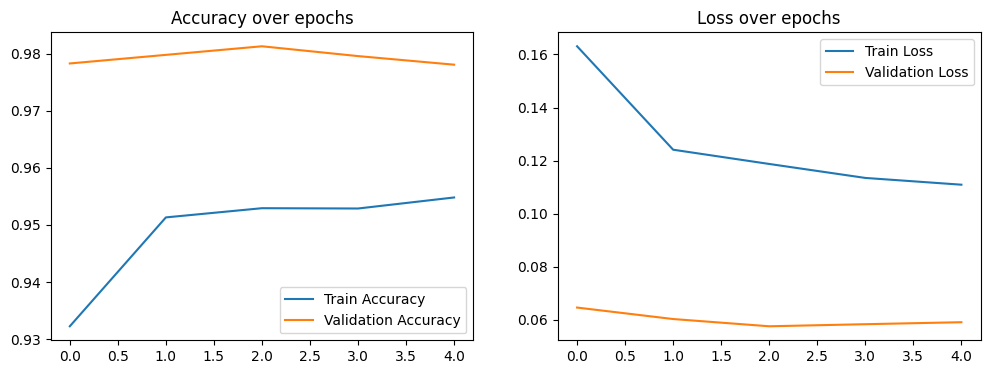

146/146 ━━━━━━━━━━━━━━━━━━━━ 95s 647ms/step - accuracy: 0.9821 - loss: 0.0513

Validation Accuracy: 97.81%


In [9]:
# Plot training history
import matplotlib.pyplot as plt # Import matplotlib.pyplot

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(val_batches) # Use val_batches instead of val_generator
print(f"\nValidation Accuracy: {accuracy*100:.2f}%")